In [1]:
import networkx as nx
import numpy as np
import scipy.io
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import signal
import os
import matplotlib.pyplot as plt
import time
import nilearn.plotting
import pickle

C:\Users\evangeli\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
def flip_odd(C): #only call if lesion is in right hemisphere
    n = C.shape[0]
    assert(n % 2 == 1)
    breakpoint = (n - 1) // 2 + 1
    BS_BS = np.array(C[0, 0]).reshape(1,1)
    BS_HH = C[0, 1:breakpoint].reshape(1,-1)
    BS_AH = C[0, breakpoint:].reshape(1,-1)
    HH_BS = BS_HH.T
    HH_HH = C[1:breakpoint, 1:breakpoint]
    HH_AH = C[1:breakpoint, breakpoint:]
    AH_BS = BS_AH.T
    AH_HH = HH_AH.T
    AH_AH = C[breakpoint:, breakpoint:]
    return np.block([[BS_BS, BS_AH, BS_HH], [AH_BS, AH_AH, AH_HH], [HH_BS, HH_AH, HH_HH]])

In [24]:
# Load Connectome (C) and Dysconnectome (D) for all available subjects
# Subscripts a and c mean acute (3 weeks after stroke) and cronic (3 months after)
df = pd.read_excel('korea63_clinic_23102018.xlsx')
df = df[['ID','Stroke lesion']][4:]
subject_list = df['ID']


Ca = dict()
Da = dict()
Cc = dict()
Dc = dict()

Ca_simm = dict()
Da_simm = dict()
Cc_simm = dict()
Dc_simm = dict()

Ca_bin = dict()
Da_bin = dict()
Cc_bin = dict()
Dc_bin = dict()

Subjs = dict()
subject_list = [1,3,4,6,7,8,9,11,12,13,14,17,18,19,22,23,24,26,27,30,31,33,35,37,38,40,42,43,44,45,46,47,49,50,52,54,55,56,57,58,59,60,62,63,64,65,66,70,71,77,79,80,84,85,87,88,89,90,91,93,94,95]

for ind,subject in enumerate(subject_list):
    Ca[ind] = np.loadtxt('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/analysis/VECTOR_connectome_HD_FA_ta.txt' % subject)
    Da[ind] = np.loadtxt('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/analysis/VECTOR_dysconnectome_HD_ta.txt' % subject)
    Cc[ind] = np.loadtxt('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/analysis/VECTOR_connectome_HD_FA_tc.txt' % subject)
    Dc[ind] = np.loadtxt('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/analysis/VECTOR_dysconnectome_HD_tc.txt' % subject)
    Ca[ind] = np.delete(Ca[ind], (7), axis=0)
    Ca[ind] = np.delete(Ca[ind], (7), axis=1)
    Ca[ind] = np.delete(Ca[ind], (173), axis=0)
    Ca[ind] = np.delete(Ca[ind], (173), axis=1)
    Da[ind] = np.delete(Da[ind], (7), axis=0)
    Da[ind] = np.delete(Da[ind], (7), axis=1)
    Da[ind] = np.delete(Da[ind], (173), axis=0)
    Da[ind] = np.delete(Da[ind], (173), axis=1)
    Cc[ind] = np.delete(Cc[ind], (7), axis=0)
    Cc[ind] = np.delete(Cc[ind], (7), axis=1)
    Cc[ind] = np.delete(Cc[ind], (173), axis=0)
    Cc[ind] = np.delete(Cc[ind], (173), axis=1)
    Dc[ind] = np.delete(Dc[ind], (7), axis=0)
    Dc[ind] = np.delete(Dc[ind], (7), axis=1)
    Dc[ind] = np.delete(Dc[ind], (173), axis=0)
    Dc[ind] = np.delete(Dc[ind], (173), axis=1)
    np.fill_diagonal(Ca[ind], 0)
    np.fill_diagonal(Da[ind], 0)
    np.fill_diagonal(Cc[ind], 0)
    np.fill_diagonal(Dc[ind], 0)
    Ca_bin[ind] = (Ca[ind] > 0)*1
    Cc_bin[ind] = (Cc[ind] > 0)*1
    Da_bin[ind] = (Da[ind] > 0.1)*1
    Dc_bin[ind] = (Dc[ind] > 0.1)*1
    
    Ca_simm[ind] = Ca[ind] + Ca[ind].T
    Cc_simm[ind] = Cc[ind] + Cc[ind].T
    Da_simm[ind] = Da[ind] + Da[ind].T
    Dc_simm[ind] = Dc[ind] + Dc[ind].T
    
    if df['Stroke lesion'][ind+4] == 1: #i.e. if stroke is in right hemisphere, we flip
        Ca_simm[ind] = flip_odd(Ca_simm[ind])
        Da_simm[ind] = flip_odd(Da_simm[ind])
        Cc_simm[ind] = flip_odd(Cc_simm[ind])
        Dc_simm[ind] = flip_odd(Dc_simm[ind])

In [17]:
def kOrderDysconnectome(C, D, K):
    #this function returns the matrix D_k of higher order dysconnectome coloring the nodes: red=1st, green=2nd, orange=3rd, blue=4th, purple=5th order
    
    N = C.shape[0]
    rows, cols = np.matrix.nonzero(D)
    
    dysconnectome_edges = len(rows)
    
    L_1 = sorted(np.unique(list(rows) + list(cols)))
    nodes_color = {l : 'red' for l in L_1}
    C_k = np.copy( C - D)
    D_k = np.copy(D)
    v = np.zeros((2,0), dtype=int)
    colors = ['green','orange', 'blue', 'purple']

    visited = np.asarray([rows,cols]).T
    visited_edges = list(visited)
    for idx,el in enumerate(visited_edges):
        visited_edges[idx]=list(el)
        
    L_k = np.copy(L_1)    
    L_old = len(L_1)
    visited_nodes = list(L_1)
    new=[]
    for k in range(K-1):
        w = np.zeros((2,0), dtype=int)
        new = []
        for l in L_k:
            for j in range(l):
                if (C_k[l,j]>0):
                    if [l,j] and [j,l] not in visited_edges:
                        visited_edges.append([l,j])
                        if j not in visited_nodes:
                            D_k[l,j]=-k-2
                            visited_nodes.append(j)
                            new.append(j)
                        else: 
                            D_k[l,j]=-k-2+1
                        C_k[l,j]=0           
                    w1 = np.array([[l],[j]], dtype=int)
                    w = np.array(np.concatenate((w,w1),axis=1), dtype=int) 
                    #nodes_color=np.array(np.cancatenate((nodes_color,[j, -k-2], axis=0)
            for j in range(l,N):
                if (C_k[j,l]>0):
                    if [l,j] and [j,l] not in visited_edges:
                        visited_edges.append([l,j])
                        if j not in visited_nodes: 
                            visited_nodes.append(j)
                            D_k[j,l]=-k-2
                            new.append(j)
                        else:  
                            D_k[j,l]=-k-2+1
                        C_k[j,l]=0
                    w1 = np.array([[l],[j]], dtype=int)
                    w = np.array(np.concatenate((w,w1),axis=1), dtype=int)
                    #nodes_color=np.array(np.cancatenate((nodes_color,[j, -k-2], axis=0)
        v = np.array(np.concatenate((v,w),axis=1), dtype=int)
        #L_k = visited_nodes[L_old :]
        #L_old = len(L_k)
        L_k = new
        App = (D_k== -1)*-1
        D_k = D_k+App
        for t in new:
            nodes_color[t] = colors[k]
    return D_k, nodes_color
            

In [18]:
#Coordinates of the parcellation
MNI = pd.read_excel('Parcellation_MNI_Coord_COG.xlsx', sheet_name='HD')
node_coords = MNI.as_matrix(columns=['COG_x', 'COG_y', 'COG_z'])
medial_wall_nodes=[7, 174]
node_coords = np.delete(node_coords, medial_wall_nodes, axis=0)
coordinates =  pd.read_csv('Parcellation.csv', delimiter=';')

C:\Users\evangeli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
#Compute the betwenness centrality and the closeness centrality for dysconnectomes at acute and chronic phases for for all the subjects for each nod
dysconnectome_betcent = {}
dysconnectome_closcent = {}
dysconnectome_betcent_chronic = {}
dysconnectome_closcent_chronic = {}
for ind,subject in enumerate(subject_list):
    Dysc_a_bin = Da_bin[ind]
    Dysc_c_bin = Dc_bin[ind]
    dysconnectome_betcent[subject] = nx.betweenness_centrality(nx.from_numpy_array(Dysc_a_bin+np.transpose(Dysc_a_bin)))
    dysconnectome_closcent[subject] = nx.closeness_centrality(nx.from_numpy_array(Dysc_a_bin+np.transpose(Dysc_a_bin)))
    dysconnectome_betcent_chronic[subject] = nx.betweenness_centrality(nx.from_numpy_array(Dysc_c_bin+np.transpose(Dysc_c_bin)))
    dysconnectome_closcent_chronic[subject] = nx.closeness_centrality(nx.from_numpy_array(Dysc_c_bin+np.transpose(Dysc_c_bin)))
with open('../mri-analysis/data/Dysconnectome/Matrices/betweenness_D.pickle' ,  'wb') as handle:
    pickle.dump(dysconnectome_betcent, handle)
with open('../mri-analysis/data/Dysconnectome/Matrices/closeness_D.pickle' ,  'wb') as handle:
    pickle.dump(dysconnectome_closcent, handle)
with open('../mri-analysis/data/Dysconnectome/Matrices/betweenness_D_chronic.pickle' ,  'wb') as handle:
    pickle.dump(dysconnectome_betcent_chronic, handle)
with open('../mri-analysis/data/Dysconnectome/Matrices/closeness_D_chronic.pickle' ,  'wb') as handle:
    pickle.dump(dysconnectome_closcent_chronic, handle)

In [20]:
#Compute Pearson correlation coefficient and P-value between the Clinical scores (Fugl-mayer) and Betwenness, Closenness
y = np.array(pd.read_excel('Korea63_ClinicClasses_Lesionvolume.xlsx')['FMUE ta AH/66'])
y_c= np.array(pd.read_excel('Korea63_ClinicClasses_Lesionvolume.xlsx')['FMUE tc AH/66'])
Pearson_betw_Da = []
Pearson_clos_Da = []
P_value_betw_Da = []
P_value_clos_Da = []
Pearson_betw_Dc = []
Pearson_clos_Dc = []
P_value_betw_Dc = []
P_value_clos_Dc = []
G = nx.from_numpy_array(Dysc_a_bin)
for node in G.nodes:
    x_betw = np.array([dysconnectome_betcent[subject][node] for subject in subject_list])
    x_clos = np.array([dysconnectome_closcent[subject][node] for subject in subject_list])
    x_betw_chronic = np.array([dysconnectome_betcent_chronic[subject][node] for subject in subject_list])
    x_clos_chronic = np.array([dysconnectome_closcent_chronic[subject][node] for subject in subject_list])
    #plt.scatter(x_bet,y)
    #plt.show()
    from scipy.stats.stats import pearsonr
    [Pearson_betw, P_value_betw] = pearsonr(x_betw, y)
    [Pearson_clos, P_value_clos] = pearsonr(x_clos, y)
    [Pearson_betw_c, P_value_betw_c] = pearsonr(x_betw_chronic, y_c)
    [Pearson_clos_c, P_value_clos_c] = pearsonr(x_clos_chronic, y_c)
    Pearson_betw_Da.append(Pearson_betw)
    P_value_betw_Da.append(P_value_betw)
    Pearson_betw_Dc.append(Pearson_betw_c)
    P_value_betw_Dc.append(P_value_betw_c)
    Pearson_clos_Da.append(Pearson_clos)
    P_value_clos_Da.append(P_value_clos)
    Pearson_clos_Dc.append(Pearson_clos_c)
    P_value_clos_Dc.append(P_value_clos_c)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_betcent_Da.npy',Pearson_betw_Da)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_closcent_Da.npy',Pearson_clos_Da)
np.save('../mri-analysis/data/Dysconnectome/Matrices/P_value_betw_Da.npy',P_value_betw_Da)
np.save('../mri-analysis/data/Dysconnectome/Matrices/P_value_clos_Da.npy',P_value_clos_Da)

np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_betcent_Dc.npy',Pearson_betw_Dc)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_closcent_Dc.npy',Pearson_clos_Dc)
np.save('../mri-analysis/data/Dysconnectome/Matrices/P_value_betw_Dc.npy',P_value_betw_Dc)
np.save('../mri-analysis/data/Dysconnectome/Matrices/P_value_clos_Dc.npy',P_value_clos_Dc)

In [21]:
#Compute Pearson correlation coefficient and P-value between the Clinical scores (Fugl-mayer) and Smallworldness, Efficency for acute and chronic
x_eff = np.load('../mri-analysis/data/Dysconnectome/Matrices/eff_Da.npy')
x_SW = np.load('../mri-analysis/data/Dysconnectome/Matrices/SWI_Da.npy')
x_eff_c = np.load('../mri-analysis/data/Dysconnectome/Matrices/eff_Dc.npy')
x_SW_c = np.load('../mri-analysis/data/Dysconnectome/Matrices/SWI_Dc.npy')
y = np.array(pd.read_excel('Korea63_ClinicClasses_Lesionvolume.xlsx')['FMUE ta AH/66'])
y_c = np.array(pd.read_excel('Korea63_ClinicClasses_Lesionvolume.xlsx')['FMUE tc AH/66'])
from scipy.stats.stats import pearsonr
P_eff = pearsonr(x_eff, y)
P_SW = pearsonr(x_SW, y)
P_eff_c = pearsonr(x_eff_c, y_c)
P_SW_c = pearsonr(x_SW_c, y_c)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_eff_Da.npy', P_eff)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_SW_Da.npy', P_SW)   
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_eff_Dc.npy', P_eff_c)
np.save('../mri-analysis/data/Dysconnectome/Matrices/Person_SW_Dc.npy', P_SW_c)   

In [22]:
import matplotlib.gridspec as gridspec

def plot_dysc_graph(G, nodes_color, fig, outer, ind, subject):
    
    posx = np.array(coordinates['COG_x'])
    posy = np.array(coordinates['COG_y'])
    posz = np.array(coordinates['COG_z'])
    
    inner = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[ind], wspace=0.1, hspace=0.1)
    

    #fig = plt.figure(figsize=(30,10))
    #fig.suptitle(title, fontsize=16)
    
    ax = plt.Subplot(fig, inner[0])
    #plt.subplot(1,3,1)
    pos = dict((n,(posx[n],-posy[n] )) for n in G.nodes())
    #ids = [n for n in np.where(posz>np.mean(posz))[0]]
    nx.draw(G, pos=pos,node_size=40,  node_color=[nodes_color[n] for n in range(len(nodes_color))], edge_color='k', width=0.04, ax=ax)
    ax.set_title('Subject %d, axial' % subject)
    fig.add_subplot(ax)
        
    ax = plt.Subplot(fig, inner[1])
    #plt.subplot(1,3,2)
    pos = dict((n,(posx[n],posz[n] )) for n in G.nodes())
    #ids =[n for n in np.where(posy<=np.mean(posy))[0]]
    nx.draw(G, pos=pos,node_size=40, node_color=[nodes_color[n] for n in range(len(nodes_color))], edge_color='k', width=0.04, ax=ax)
    ax.set_title('Subject %d, coronal' % subject)
    fig.add_subplot(ax)
   
    ax = plt.Subplot(fig, inner[2])
    #plt.subplot(1,3,3)
    pos = dict((n,(-posy[n],posz[n] )) for n in G.nodes())
    #ids = [n for n in np.where(posx>np.mean(posx))[0] ]
    nx.draw(G, pos=pos,node_size=40,node_color=[nodes_color[n] for n in range(len(nodes_color)) ], edge_color='k', width=0.03, ax=ax)
    ax.set_title('Subject %d, saggital' % subject)
    fig.add_subplot(ax)
    

In [23]:
def kOrderDensity(D_k, K):
    #this function returns the vector of the densities of D for each order of disconnection
    density=[]
    N = D_k.shape[0]
    row1, col1 = np.where(D_k == 1)
    old = 2*len(row1)/(N*(N-1))
    density.append(old)
    rows, cols = np.matrix.nonzero(D_k)
    density_full = 2*len(rows)/(N*(N-1))
    for k in range(K-1):
        rowk , colk = np.where(D_k == -k-2)
        edges = 2*len(rowk)/(N*(N-1)) + old
        density.append(edges)
        old = edges
        rowk = []
        colk = []
    return density

In [25]:
fig = plt.figure(figsize=(30, 10*len(subject_list)))
outer = gridspec.GridSpec(len(subject_list), 1, wspace=0.2, hspace=0.2, figure=fig)

for ind,subject in enumerate(subject_list):
    
    D_k, nodes_color = kOrderDysconnectome(Ca_bin[ind], Da_bin[ind],3)
    G = nx.from_numpy_array(D_k)
    density_D_k = kOrderDensity(D_k, 3)
    node_color = [nodes_color[i] for i in range(333)]
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #plot_dysc_graph(G, node_color, fig, outer, ind, subject)
    np.save('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/ta/D_k.npy' %subject, D_k)
    np.save('../mri-analysis/data/Dysconnectome/Matrices/sub%03d/ta/density_D_k.npy' %subject, density_D_k)
plt.savefig('../mri-analysis/data/Dysconnectome/Matrices/plot_dysconnectomes.png')

<Figure size 2160x44640 with 0 Axes>

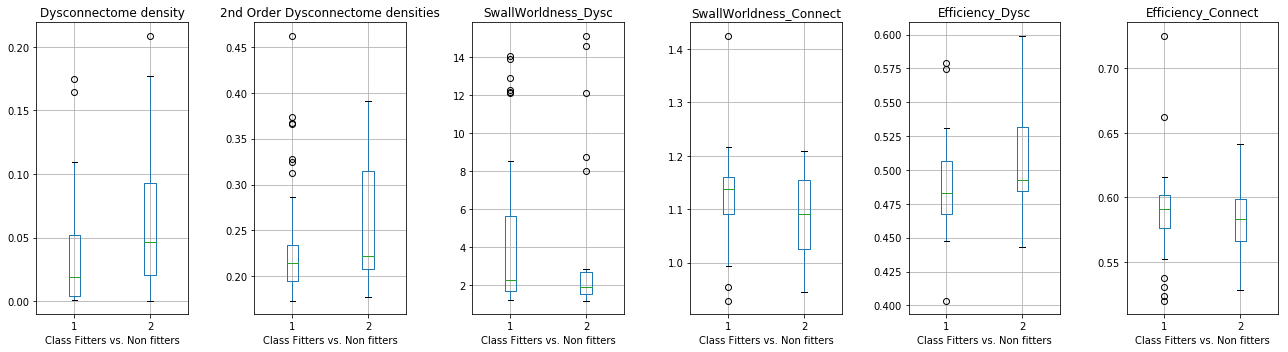

In [28]:
#Boxplot for Fitters and Non-Fitters with the following metrics: 
# density of Dysconnectome(1st order)
# density of Dysconnectome(2nd order)
#Smallworldness of Dysconnectome (1st order)
#Smallworldness of Connectome
# Efficiency of Dysconnectome 
# Efficiency of Connectome 
df = pd.read_excel('Korea63_ClinicClasses_Lesionvolume_fitters.xlsx')
densities_1 = []
densities_2 = []
Sw = np.load('../mri-analysis/data/Dysconnectome/Matrices/SWI_Da.npy')
Sw_Connect = np.load('../mri-analysis/data/Dysconnectome/Matrices/SWI_Ca.npy')
Eff = np.load('../mri-analysis/data/Dysconnectome/Matrices/eff_Da.npy')
Eff_Connect = np.load('../mri-analysis/data/Dysconnectome/Matrices/eff_Ca.npy')

for subject in df['ID']:
    if subject == 'sub053': 
        densities_1.append(np.nan)
        densities_2.append(np.nan)
        
    else:
        density_1 = np.load('../mri-analysis/data/Dysconnectome/Matrices/%s/ta/density_D_k.npy' % subject)[0]
        density_2 = np.load('../mri-analysis/data/Dysconnectome/Matrices/%s/ta/density_D_k.npy' % subject)[1]
        
        
        densities_1.append(density_1)
        densities_2.append(density_2)
        
df = df.join(pd.DataFrame({'Dysconnectome density' : densities_1, '2nd Order Dysconnectome densities': densities_2, 'SwallWorldness_Dysc': Sw,'SwallWorldness_Connect': Sw_Connect, 'Efficiency_Dysc': Eff, 'Efficiency_Connect': Eff_Connect}))
fig, axes = plt.subplots(ncols=6, figsize=(18,5))

df.boxplot(column=['Dysconnectome density'], by='Class Fitters vs. Non fitters', ax=axes[0])
df.boxplot(column=['2nd Order Dysconnectome densities'], by='Class Fitters vs. Non fitters', ax=axes[1])
df.boxplot(column=['SwallWorldness_Dysc'], by='Class Fitters vs. Non fitters', ax=axes[2])
df.boxplot(column=['SwallWorldness_Connect'], by='Class Fitters vs. Non fitters', ax=axes[3])
df.boxplot(column=['Efficiency_Dysc' ], by='Class Fitters vs. Non fitters', ax=axes[4])
df.boxplot(column=['Efficiency_Connect' ], by='Class Fitters vs. Non fitters', ax=axes[5])
plt.suptitle("")
fig.tight_layout()
plt.savefig('../mri-analysis/data/Dysconnectome/Matrices/boxplots.png')